In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
from physics_flow_matching.unet.mlp import EM_MLP_Wrapper as MLP
import torch
from torch import nn
from physics_flow_matching.multi_fidelity.synthetic.dists.base import get_distribution

In [159]:
model_neg_spi =  MLP(input_dim=2,
                hidden_dims= [256]*5,
                output_dim=1,
                act1=nn.functional.silu,
                act2=None
            )
model_neg_spi.load_state_dict(torch.load('/home/meet/FlowMatchingTests/EnergyMatching/experiments/toy2d/exps/exp_4/saved_state/checkpoint_60.pth')['model_state_dict'])
model_neg_spi.eval();
model_neg_spi.to(device='cuda')

model_spi =  MLP(input_dim=2,
                hidden_dims= [256]*5,
                output_dim=1,
                act1=nn.functional.silu,
                act2=None
            )
model_spi.load_state_dict(torch.load('/home/meet/FlowMatchingTests/EnergyMatching/experiments/toy2d/exps/exp_3/saved_state/checkpoint_60.pth')['model_state_dict'])
model_spi.eval();
model_spi.to(device='cuda')

model = lambda t, x : torch.min(model_spi(t, x), model_neg_spi(t, x)) #-torch.log(torch.sum(torch.exp(torch.stack([- 0.8* model_spi(t, x), - 0.8* model_neg_spi(t, x)], dim=-1)), axis=-1)) # torch.min(model_spi(t, x), model_neg_spi(t, x)) #torch.log(torch.sum(torch.exp(torch.stack([model_spi(t, x), model_neg_spi(t, x)], dim=-1)), axis=-1))

/tmp/ipykernel_1494693/1559212440.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_neg_spi.load_state_dict(torch.load('/home/meet/FlowMatchingTests/EnergyMatching/e

In [160]:
x_init = get_distribution('gaussian').sample(10000).to('cuda')
# m, s = x_init.mean(dim=0, keepdim=True), x_init.std(dim=0, keepdim=True)

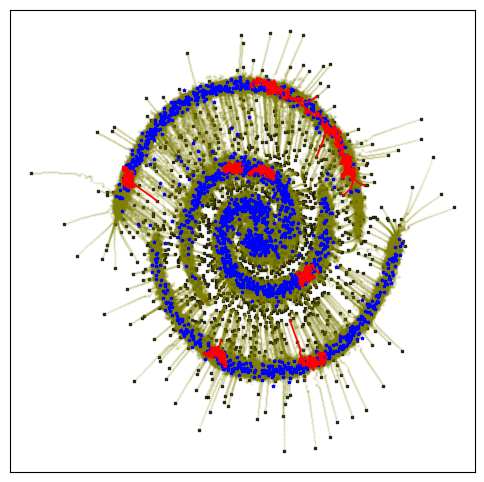

In [161]:
from experiments.toy2d.utils_2D_new import simulate_piecewise_length, plot_trajectories_custom

# Use the same tau_star, epsilon_max we used for training.
x = (x_init)

traj_np, times_np = simulate_piecewise_length(
    model,
    x,
    dt=0.01,
    max_length=1000,
    tau_star=0.8,
    epsilon_max=0.01
)

plot_trajectories_custom(traj_np)

In [162]:
import matplotlib.pyplot as plt

(-3.0, 3.0)

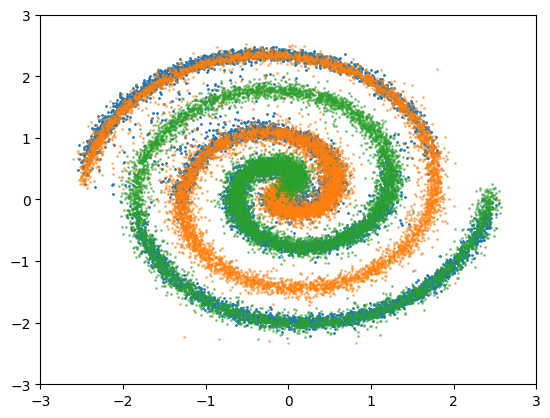

In [163]:
plt.scatter(traj_np[-1, :, 0], traj_np[-1, :, 1], s=1)
plt.scatter(traj_np_spi[-1, :, 0], traj_np_spi[-1, :, 1], s=1, alpha=0.5)
plt.scatter(traj_np_spi_[-1, :, 0], traj_np_spi_[-1, :, 1], s=1, alpha=0.5)


plt.ylim(-3, 3)
plt.xlim(-3, 3)